# Question answering with BERT (Hugging Face)
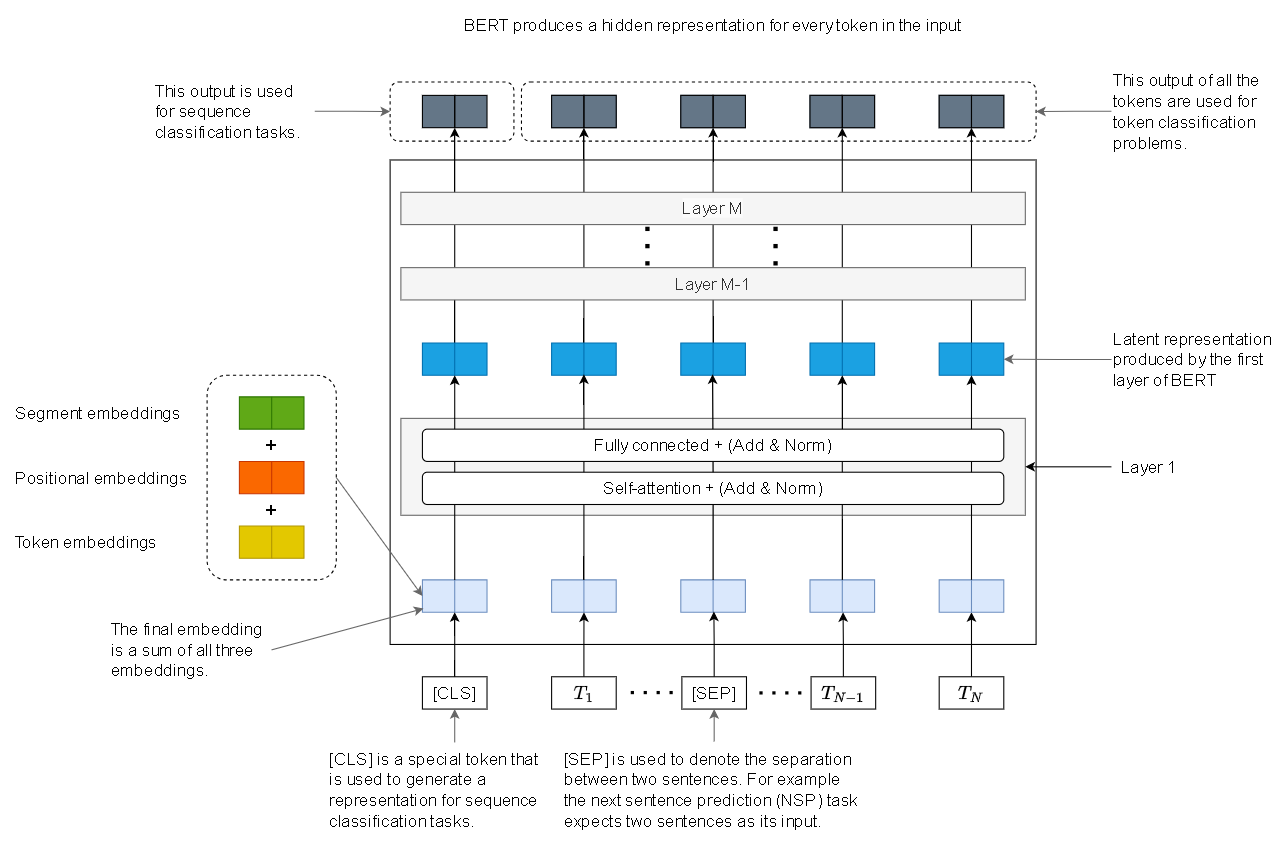

**Warning**: This a very memory intensive exercise. It is recommended to havea GPU with a large memory if running on a GPU-powered Machine. This exercise was run on a Nvidia RTX 2070 8GB with a training batch size of `4`.

## Importing libraries

In [4]:
import random
import numpy as np
import transformers
from datasets import load_dataset
from transformers import DistilBertTokenizerFast
from transformers import DistilBertConfig, TFDistilBertForQuestionAnswering
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
import time

# BERT Applications
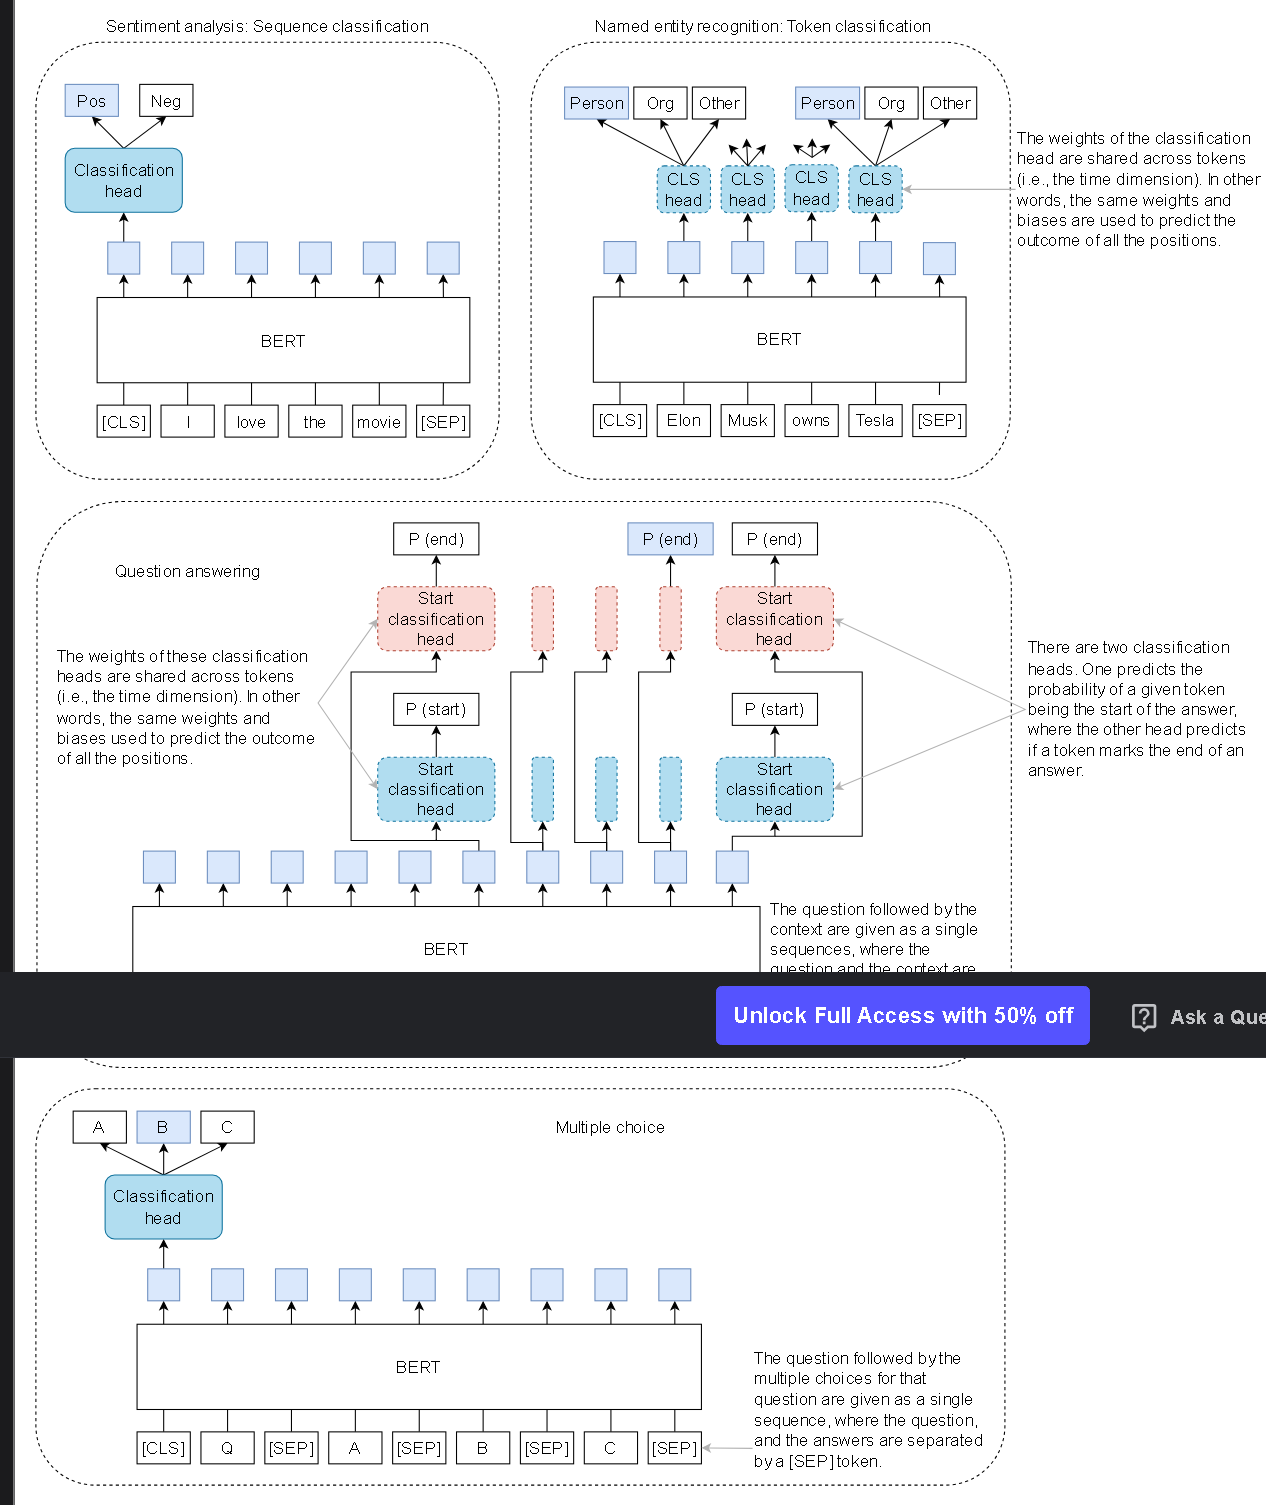

## Downloading the dataset

For this, we will be using the [SQUAD v1 dataset](https://rajpurkar.github.io/SQuAD-explorer/). It is a question-answering dataset. You are provided with a question, a context (e.g., a paragraph in which the answer to the question may exist), and finally the answer. Your goal is to predict the answer given the question and the context.

In [5]:
# Section 13.3

from datasets import load_dataset

dataset = load_dataset("squad")

print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


## Printing the first five samples in the training set.

In [6]:
for q, a in zip(dataset["train"]["question"][2:6], dataset["train"]["answers"][2:6]):
    print(f"{q} -> {a}")

The Basilica of the Sacred heart at Notre Dame is beside to which structure? -> {'text': ['the Main Building'], 'answer_start': [279]}
What is the Grotto at Notre Dame? -> {'text': ['a Marian place of prayer and reflection'], 'answer_start': [381]}
What sits on top of the Main Building at Notre Dame? -> {'text': ['a golden statue of the Virgin Mary'], 'answer_start': [92]}
When did the Scholastic Magazine of Notre dame begin publishing? -> {'text': ['September 1876'], 'answer_start': [248]}


## Correcting incorrect offsets of the provided answers

The answers are provided by means of the starting index (`answer_start`) and the answer itself (`text`). We will add `answer_end`, which will denote the index of the position the answer ends.

In [ ]:
def compute_end_index(answers, contexts):
    """ Add end index to answers """

    fixed_answers = []
    for answer, context in zip(answers, contexts):

        gold_text = answer['text'][0]
        answer['text'] = gold_text
        start_idx = answer['answer_start'][0]
        answer['answer_start'] = start_idx

        # Make sure the starting index is valid and there is an answer
        assert start_idx >=0 and len(gold_text.strip()) > 0

        end_idx = start_idx + len(gold_text)
        answer['answer_end'] = end_idx

        # Make sure the corresponding context matches the actual answer
        assert context[start_idx:end_idx] == gold_text

        fixed_answers.append(answer)

    return fixed_answers, contexts

train_questions = dataset["train"]["question"]
print("Training data corrections")
train_answers, train_contexts = compute_end_index(
    dataset["train"]["answers"], dataset["train"]["context"]
)
test_questions = dataset["validation"]["question"]
print("\nValidation data correction")
test_answers, test_contexts = compute_end_index(
    dataset["validation"]["answers"], dataset["validation"]["context"]
)

Training data corrections

Validation data correction


## Question answering with BERT

Now we will start to train a question-answering model. The pretrained model we'll be using is [Bert](https://arxiv.org/pdf/1810.04805.pdf).

### Defining the tokenizer

In [ ]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Converting some text to tokens with the tokenizer

In [ ]:
context = "This is the context"
question = "This is the question"

token_ids = tokenizer(context, question, return_tensors='tf')
print(token_ids)
print(tokenizer.convert_ids_to_tokens(token_ids['input_ids'].numpy()[0]))

{'input_ids': <tf.Tensor: shape=(1, 11), dtype=int32, numpy=
array([[ 101, 2023, 2003, 1996, 6123,  102, 2023, 2003, 1996, 3160,  102]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 11), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 11), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
['[CLS]', 'this', 'is', 'the', 'context', '[SEP]', 'this', 'is', 'the', 'question', '[SEP]']


2022-04-28 08:13:57.077097: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 08:13:57.077629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:13:57.078009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 08:13:57.078330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Converting the inputs to tokens

In adition to converting inputs to tokens and adding special tokens, it will truncate and pad inputs to the maximum length of the sequences defined in the model config. For example, you can check model config with `tokenizer.model_max_length`.

In [ ]:
# Encode train data
# train_encodings -> transformers.tokenization_utils_base.BatchEncoding
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True, return_tensors='tf')
print(f"train_encodings.shape: {train_encodings['input_ids'].shape}")
# Encode test data
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True, return_tensors='tf')
print(f"test_encodings.shape: {test_encodings['input_ids'].shape}")


train_encodings.shape: (87599, 512)
test_encodings.shape: (10570, 512)


### Dealing with truncated answers

In the original dataset the `answer_start` and `answer_end` denote the *character*-level position of the answer. But in the model, since we deal in tokens, we need the *token*-level position of the answer. For that, we will use the `char_to_token` function in the tokenizer. It will convert the character index to a token index.

Because we are enforcing a maximum sequence length of 512, some answers will be inevitably truncated if they are present after the 512th token. Although this is rare, we still need to take care of this as it can result in numerical errors otherwise. Therefore, if the positions are `None` (i.e., couldn't find the answer), it is set to the maximum position.

In [ ]:
def replace_char_with_token_indices(encodings, answers):
    start_positions = []
    end_positions = []
    n_updates = 0
    # Go through all the answers
    for i in range(len(answers)):

        # Get the token position for both start end char positions
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        if start_positions[-1] is None or end_positions[-1] is None:
            n_updates += 1
        # if start position is None, the answer passage has been truncated
        # In the guide, https://huggingface.co/transformers/custom_datasets.html#qa-squad
        # they set it to model_max_length, but this will result in NaN losses as the last
        # available label is model_max_length-1 (zero-indexed)
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length -1

        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length -1

    print(f"{n_updates}/{len(answers)} had answers truncated")
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

replace_char_with_token_indices(train_encodings, train_answers)
replace_char_with_token_indices(test_encodings, test_answers)

10/87599 had answers truncated
8/10570 had answers truncated


### Creating TensorFlow dataset

In [ ]:
import tensorflow as tf
from functools import partial

train_batch_size = 4
test_batch_size = 8

def data_gen(input_ids, attention_mask, start_positions, end_positions):
    """ Generator for data """
    for inps, attn, start_pos, end_pos in zip(input_ids, attention_mask, start_positions, end_positions):

        yield (inps, attn), (start_pos, end_pos)

print("Creating train data")

# Define the generator as a callable (not the generator it self)
train_data_gen = partial(data_gen,
    input_ids=train_encodings['input_ids'], attention_mask=train_encodings['attention_mask'],
    start_positions=train_encodings['start_positions'], end_positions=train_encodings['end_positions']
)

# Define the dataset
train_dataset = tf.data.Dataset.from_generator(
    train_data_gen, output_types=(('int32', 'int32'), ('int32', 'int32'))
)
# Shuffle the data
train_dataset = train_dataset.shuffle(1000)
print('\tDone')

# Valid set is taken as the first 10,000 samples in the shuffled set
valid_dataset = train_dataset.take(10000)
valid_dataset = valid_dataset.batch(train_batch_size)

# Rest is kept as the training data
train_dataset = train_dataset.skip(10000)
train_dataset = train_dataset.batch(train_batch_size)

# Create test data
print("Creating test data")

# Define the generator as a callable
test_data_gen = partial(data_gen,
    input_ids=test_encodings['input_ids'], attention_mask=test_encodings['attention_mask'],
    start_positions=test_encodings['start_positions'], end_positions=test_encodings['end_positions']
)
test_dataset = tf.data.Dataset.from_generator(
    test_data_gen, output_types=(('int32', 'int32'), ('int32', 'int32'))
)
test_dataset = test_dataset.batch(test_batch_size)
print("\tDone")

Creating train data
	Done
Creating test data
	Done


### Defining the model

Here we define a DistilBert model (particularly a TF variant).

In [ ]:
from transformers import BertConfig,  TFBertForQuestionAnswering

config = BertConfig.from_pretrained("bert-base-uncased", return_dict=False)
print(config)
model =  TFBertForQuestionAnswering.from_pretrained("bert-base-uncased", config=config)

def tf_wrap_model(model):
    """ Wraps the Hugging Face model with in the Keras functional API """

    # If this is not wrapped in a Keras model by taking the correct tensors from
    # TFQuestionAnsweringModelOutput produced, you will get the following error
    # setting return_dict did not seem to work as it should

    # TypeError: The two structures don't have the same sequence type.
    # Input structure has type <class 'tuple'>, while shallow structure has type
    # <class 'transformers.modeling_tf_outputs.TFQuestionAnsweringModelOutput'>.

    # Define inputs
    input_ids = tf.keras.layers.Input([None,], dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input([None,], dtype=tf.int32, name="attention_mask")

    # Define the output (TFQuestionAnsweringModelOutput)
    out = model([input_ids, attention_mask])

    # Get the correct attributes in the produced object to generate an output tuple
    wrap_model = tf.keras.models.Model([input_ids, attention_mask], outputs=(out.start_logits, out.end_logits))

    return wrap_model


# Define and compile the model

# Keras will assign a separate loss for each output and add them together. So we'll just use the standard CE loss
# instead of using the built-in model.compute_loss, which expects a dict of outputs and averages the two terms.
# Note that this means the loss will be 2x of when using TFTrainer since we're adding instead of averaging them.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_v2 = tf_wrap_model(model)
model_v2.compile(optimizer=optimizer, loss=loss, metrics=[acc])


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "return_dict": false,
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training the model

In [ ]:
import time

t1 = time.time()

model_v2.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2
)

t2 = time.time()

print(f"It took {t2-t1} seconds to complete the training")

Epoch 1/2
19400/19400 [==============================] - 7175s 369ms/step - loss: 2.7193 - tf_bert_for_question_answering_loss: 1.4153 - tf_bert_for_question_answering_1_loss: 1.3040 - tf_bert_for_question_answering_sparse_categorical_accuracy: 0.5975 - tf_bert_for_question_answering_1_sparse_categorical_accuracy: 0.6376 - val_loss: 2.1615 - val_tf_bert_for_question_answering_loss: 1.0898 - val_tf_bert_for_question_answering_1_loss: 1.0717 - val_tf_bert_for_question_answering_sparse_categorical_accuracy: 0.7120 - val_tf_bert_for_question_answering_1_sparse_categorical_accuracy: 0.7350
Epoch 2/2
19400/19400 [==============================] - 7192s 370ms/step - loss: 1.6691 - tf_bert_for_question_answering_loss: 0.8865 - tf_bert_for_question_answering_1_loss: 0.7826 - tf_bert_for_question_answering_sparse_categorical_accuracy: 0.7245 - tf_bert_for_question_answering_1_sparse_categorical_accuracy: 0.7646 - val_loss: 2.1836 - val_tf_bert_for_question_answering_loss: 1.0988 - val_tf_bert_fo

### Saving the model

In [ ]:
print(model_v2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_for_question_answering  TFQuestionAnswering  108893186  ['input_ids[0][0]',              
  (TFBertForQuestionAnswering)  ModelOutput(loss=No               'attention_mask[0][0]']         
                                ne, start_logits=(N                                               
                                one, None),                                                   

**Note:** We cannot save `model_v2` as is because it raises an error about not finding config for the transformer model layer. Therefore, we will save just the transformer model layer so that we can call the `tf_wrap_model()` function anytime and get the wrapped model.

In [ ]:
import os

# Create folders
if not os.path.exists('models'):
    os.makedirs('models')
if not os.path.exists('tokenizers'):
    os.makedirs('tokenizers')

# Save the model
model_v2.get_layer("tf_bert_for_question_answering").save_pretrained(os.path.join('models', 'bert_qa'))

# Save the tokenizer
tokenizer.save_pretrained(os.path.join('tokenizers', 'bert_qa'))



('tokenizers/bert_qa/tokenizer_config.json',
 'tokenizers/bert_qa/special_tokens_map.json',
 'tokenizers/bert_qa/vocab.txt',
 'tokenizers/bert_qa/added_tokens.json',
 'tokenizers/bert_qa/tokenizer.json')

### Testing on unseen data

In [ ]:
model_v2.evaluate(test_dataset)

1322/1322 [==============================] - 345s 261ms/step - loss: 2.2205 - tf_bert_for_question_answering_loss: 1.1325 - tf_bert_for_question_answering_1_loss: 1.0881 - tf_bert_for_question_answering_sparse_categorical_accuracy: 0.6968 - tf_bert_for_question_answering_1_sparse_categorical_accuracy: 0.7250


[2.2205309867858887,
 1.1324760913848877,
 1.088051199913025,
 0.6967833638191223,
 0.7249763607978821]

## Asking BERT a question

In [ ]:
i = 7

# Define sample question
sample_q = test_questions[i]
# Define sample context
sample_c = test_contexts[i]
# Define sample answer
sample_a = test_answers[i]

# Get the input in the format BERT accepts
sample_input = (test_encodings["input_ids"][i:i+1], test_encodings["attention_mask"][i:i+1])

def ask_bert(sample_input, tokenizer, model):
    """ This function takes an input, a tokenizer, and a model and returns the prediciton """
    out = model.predict(sample_input)
    pred_ans_start = tf.argmax(out[0][0])
    pred_ans_end = tf.argmax(out[1][0])
    print(f"{pred_ans_start}-{pred_ans_end} token ids contain the answer")
    ans_tokens = sample_input[0][0][pred_ans_start:pred_ans_end+1]

    return " ".join(tokenizer.convert_ids_to_tokens(ans_tokens))

print("Question")
print("\t", sample_q, "\n")
print("Context")
print("\t", sample_c, "\n")
print("Answer (char indexed)")
print("\t", sample_a, "\n")
print('='*50,'\n')

sample_pred_ans = ask_bert(sample_input, tokenizer, model_v2)

print("Answer (predicted)")
print(sample_pred_ans)
print('='*50,'\n')

Question
	 What is the AFC short for? 

Context
	 Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50. 

Answer (char indexed)
	 {'text': 'American Football Conference', 'answer_start': 133, 'answer_end': 161} 


27-29 token ids contain the answer
Answer (predicted)
american f